# Predicting Education History From Credit Data

## Introduction
 
A credit card is similar to a loan where you buy items within your credit limit and pay the owing amount at the end of the month. When individuals have a credit card, there is a credit amount which is a limit on the amount they can purchase, the amount they actually purchase is their bill statement, and the previous payment is the amount that was paid last month. 

We are using the default of credit card clients dataset from the UCI Machine Learning Repository which has data on 30,000 individuals and their credit history. The dataset includes each individual’s credit amount, gender, education, marital status, age, history of past payment, amount of bill statement, and amount of previous payment. The data is from Taiwan and the currency used is the New Taiwan Dollar ($NT). $1 CAD is approximately 22 $NT.

The education level is split into 4 categories. 1 represents graduate school, 2 represents university, 3 represents high school, and 4 represents other. The other category includes individuals who may not have completed high school or have education from colleges or trade schools.

The question we will answer is: How well can we predict a person's education level from their credit data? The reason we chose this question is that we think there may be a relationship between a person's education level and the amount of money they make and therefore their credit spending habits.

## Methods

In [2]:
# install required libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 8)
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [3]:
# reading in the data from github
url <- "https://github.com/zackhamza01/DSCI-100-Project/raw/main/data/creditcardcsv.csv"
credit_data <- read_csv(url, skip = 1)

# tidying the data
tidied_credit_data <- credit_data %>%
    mutate(BILL_AVG = (BILL_AMT1 + BILL_AMT2 + BILL_AMT3 + BILL_AMT4 + BILL_AMT5 + BILL_AMT6) / 6) %>%
    mutate(PAY_AVG = (PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT4 + PAY_AMT5 + PAY_AMT6) / 6) %>%
    select(EDUCATION, AGE, LIMIT_BAL, BILL_AVG, PAY_AVG) %>%
    mutate(EDUCATION = as_factor(EDUCATION)) %>%
    filter(EDUCATION == 1 | EDUCATION == 2 | EDUCATION == 3 | EDUCATION == 4) # getting rid of rows that have no explanation (0,5,6)

# splitting data into training and test sets
credit_split <- initial_split(tidied_credit_data, prop = 0.5, strata = EDUCATION)
credit_train <- training(credit_split)
credit_test <- testing(credit_split)

Parsed with column specification:
cols(
  .default = col_double()
)

See spec(...) for full column specifications.



In [4]:
# summarizing training data in a table
summary <- credit_train %>%
    group_by(EDUCATION) %>%
    summarize(count = n(), credit_limit_avg = mean(LIMIT_BAL), age_avg = mean(AGE), 
              monthly_bill_avg = mean(BILL_AVG), monthly_payment_avg = mean(PAY_AVG))

summary

`summarise()` ungrouping output (override with `.groups` argument)



EDUCATION,count,credit_limit_avg,age_avg,monthly_bill_avg,monthly_payment_avg
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,5292,215064.2,34.35639,44665.53,6589.854
2,7020,147970.1,34.69758,46911.34,4691.979
3,2458,125300.1,40.27055,41701.13,4137.858
4,58,217931.0,34.91379,46503.59,7968.101


This table allows us to get an idea of the distributions of the different columns with respect to the different education levels. Education level 4 has a much smaller number of data points which can skew the average easily due to a few anomalies.

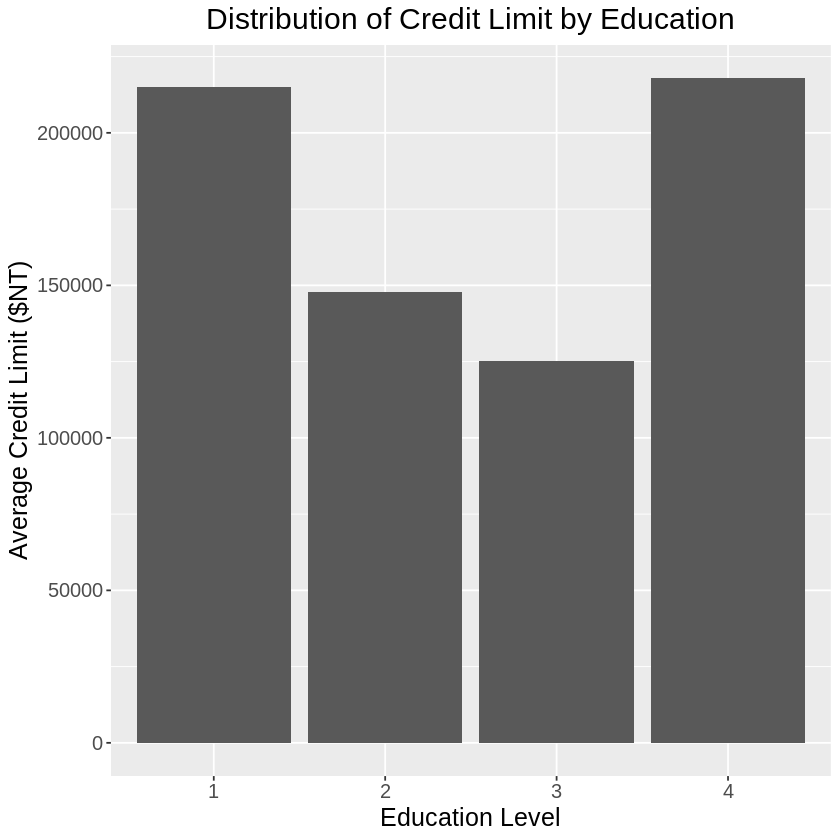

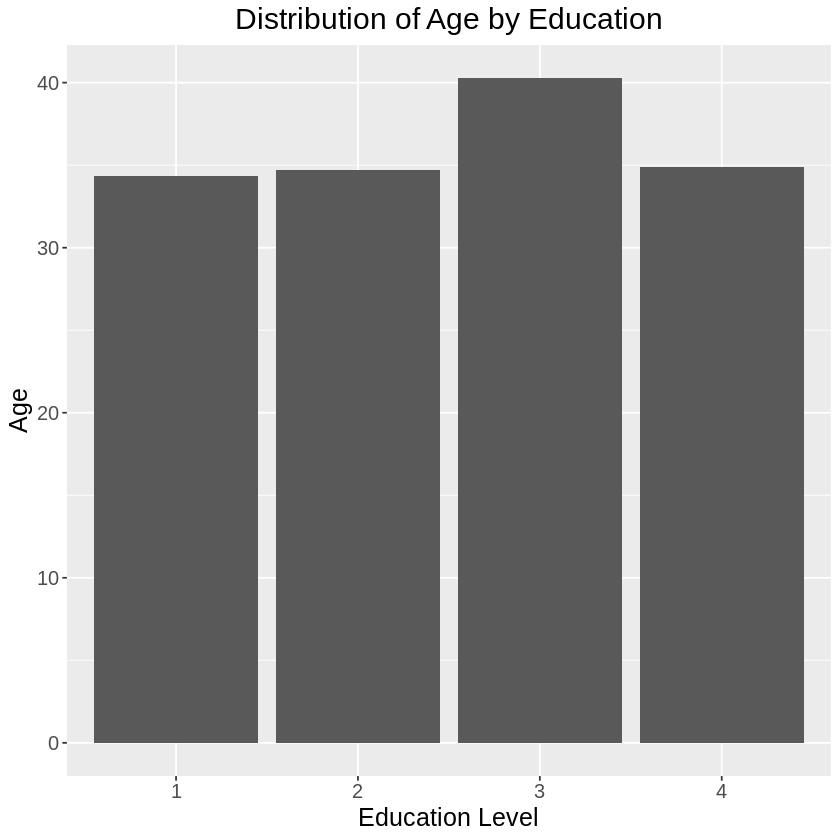

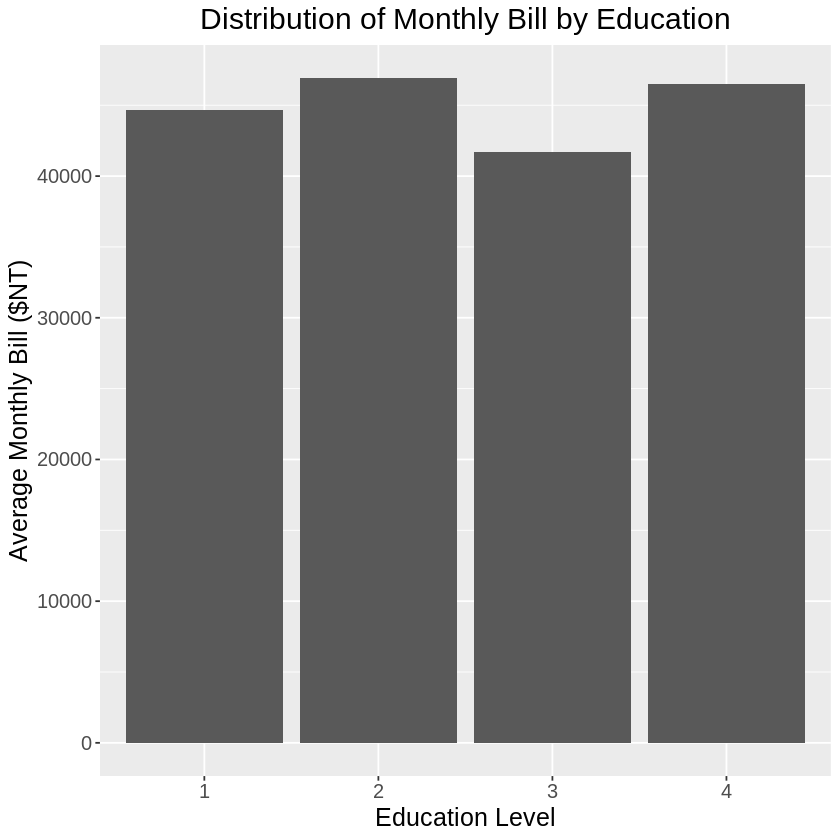

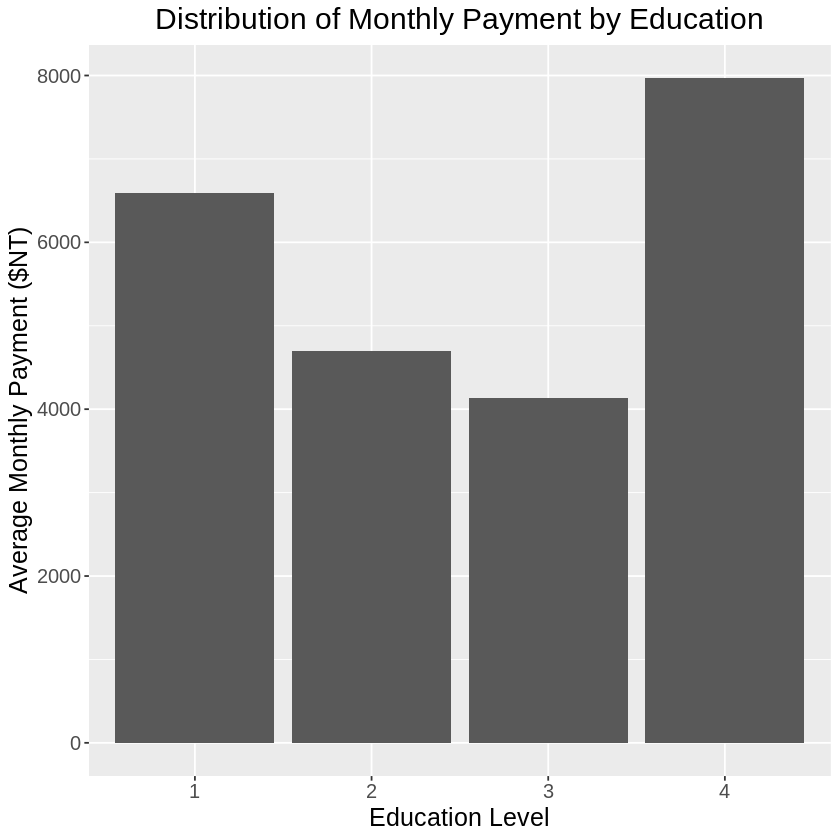

In [5]:
# visualizing data in a graph
limit_avg_plot <- summary %>%
    ggplot(aes(x = EDUCATION, y = credit_limit_avg)) +
        geom_bar(stat = "identity") +
        labs(x = "Education Level", y = "Average Credit Limit ($NT)") +
        theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5)) +
        ggtitle("Distribution of Credit Limit by Education")

age_avg_plot <- summary %>%
    ggplot(aes(x = EDUCATION, y = age_avg)) +
        geom_bar(stat = "identity") +
        labs(x = "Education Level", y = "Age") +
        theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5)) +
        ggtitle("Distribution of Age by Education")

bill_avg_plot <- summary %>%
    ggplot(aes(x = EDUCATION, y = monthly_bill_avg)) +
        geom_bar(stat = "identity") +
        labs(x = "Education Level", y = "Average Monthly Bill ($NT)") +
        theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5)) +
        ggtitle("Distribution of Monthly Bill by Education")

pay_avg_plot <- summary %>%
    ggplot(aes(x = EDUCATION, y = monthly_payment_avg)) +
        geom_bar(stat = "identity") +
        labs(x = "Education Level", y = "Average Monthly Payment ($NT)") +
        theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5)) +
        ggtitle("Distribution of Monthly Payment by Education")

limit_avg_plot
age_avg_plot
bill_avg_plot
pay_avg_plot

Plotting the distributions of the columns allows us to get an insight of how the education level relates to the other columns in the data. We used bar graphs as it is the best way to visualize a comparison of categorical data.

In [ ]:
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                            neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

recipe <- recipe(EDUCATION ~ LIMIT_BAL + PAY_AVG, data = credit_train) %>%
            step_scale(all_predictors()) %>%
            step_center(all_predictors())

vfold <- vfold_cv(credit_train, v = 5, strata = EDUCATION)

credit_fit <- workflow() %>%
                add_recipe(recipe) %>%
                add_model(knn_spec) %>%
                tune_grid(resamples = vfold, grid = 10) %>%
                collect_metrics()

! Fold1: internal: No observations were detected in `truth` for level(s): '0', '5...

! Fold2: internal: No observations were detected in `truth` for level(s): '0', '5...



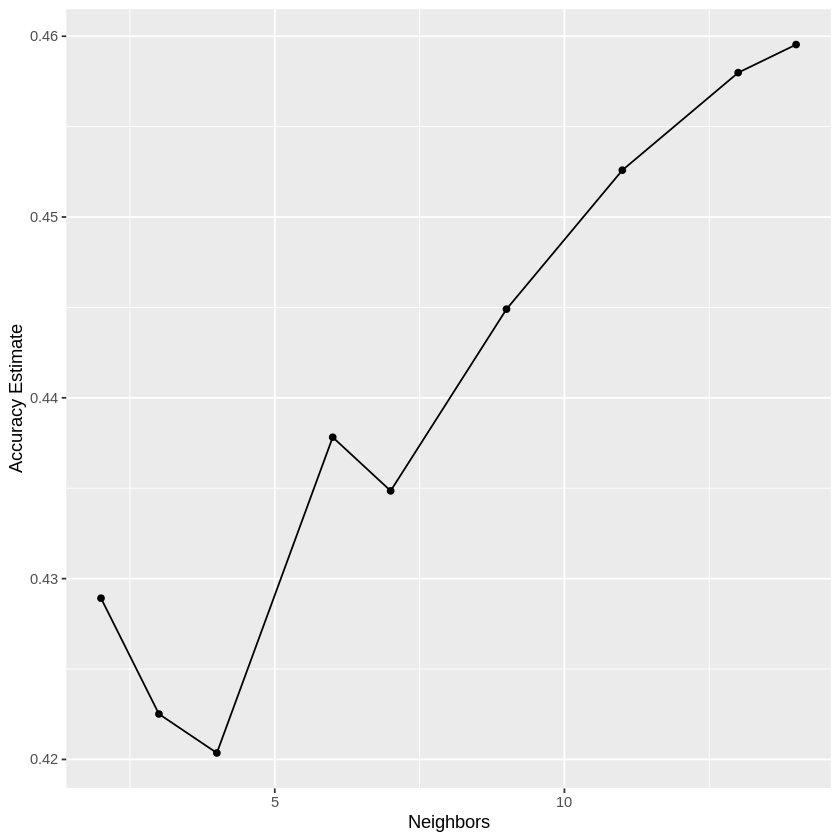

In [24]:
accuracies <- credit_fit %>%
  filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate")
accuracy_vs_k